In [20]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
# from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

$r_{ij} = r_i - r_j$
$$
U(r_{ij}) = 4\varepsilon [(\sigma/r_{ij})^{12} - (\sigma/r_{ij})^6] \\
U^*(r_{ij}) = 4[(r_{ij}^*)^{-12} - (r_{ij}^*)^{-6}] \\
\phantom{U^*(r_{ij})} = 4[(r_{ij}^*)^{-6} - 1](r_{ij}^*)^{-6} \\
$$
Force atom $j$ exerts on $i$
$$
\vec{F}^*(r_{ij}) = 48[(r_{ij}^*)^{-6} - 0.5](r_{ij}^*)^{-8} \vec{r_{ij}^*} \\
$$

[14.47681414 11.39753528]
(2, 110)
110


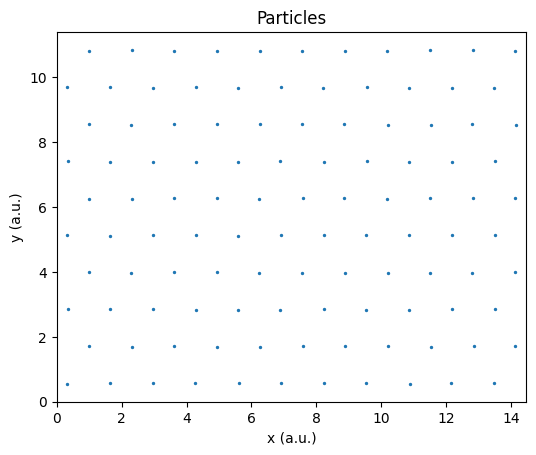

In [219]:
# SET UP RANDOM INITIAL CONDITIONS
rng = np.random.default_rng(seed=102)

X_U_MIN = 2**(1/6)*1
N_L = 10
# N = N_L*N_L
DIM = 2

DENSITY = 0.5
RANDOM_DISPLACEMENT = 0.02

def generate_square_lattice(den,n):
    step = (1 / den) ** .5
    # generate matrices of lattice coordinates
    rmat = np.array(np.meshgrid(np.arange(0,n),np.arange(0,n)),dtype=float)
    rmat += 1/2
    rmat *= step
    # convert matrices of x and y positions to vectors of x and y positions, and return
    l_wrap = n*step, n*step
    r = np.vstack(list(map(np.concatenate,rmat)))
    N = len(r[0])
    return r, l_wrap, N

def generate_triangular_lattice(den,n):
    step = (np.sqrt(3)/2 / den) ** .5
    # generate matrices of lattice coordinates
    n += (n+1)%2
    rmat = np.array(np.meshgrid(np.arange(0,n),np.arange(0,n-1)),dtype=float)
    rmat[0] += 1/4
    rmat[1] += 1/2
    rmat[0][1::2] += 1/2
    rmat[0] *= step
    rmat[1] *= step * np.sqrt(3)/2
    # convert matrices of x and y positions to vectors of x and y positions, and return
    l_wrap = n*step, (n-1)*step * np.sqrt(3)/2
    r = np.vstack(list(map(np.concatenate,rmat)))
    N = len(r[0])
    return r, l_wrap, N

# generate lattice positions
r,L,N = generate_triangular_lattice(DENSITY,N_L)
L = np.array(L)
print(L)
# add small random displacements
r += rng.uniform(-RANDOM_DISPLACEMENT,RANDOM_DISPLACEMENT,r.shape)
print(r.shape)
print(N)

T_i = 0.1
v = rng.normal(0, T_i**0.5, (DIM,N))

plt.title("Particles")
plt.xlim(0, L[0])
plt.ylim(0, L[1])
plt.xlabel("x (a.u.)")
plt.ylabel("y (a.u.)")
plt.gca().set_aspect('equal')
plt.scatter(*r, s=2)
plt.show()

R_CUTOFF: 2.5
U_CUTOFF: -0.016316891136
testing with r as [xs, ys]
[[1. 2. 3.]
 [2. 3. 4.]]
[ 5. 13. 25.]
[-0.01542711  0.          0.        ]
[[0.0377856 0.        0.       ]
 [0.0755712 0.        0.       ]]

testing with r as [x matrix, y matrix]
[[ 5. 10. 17.]
 [ 8. 13. 20.]
 [13. 18. 25.]]
[[-0.01542711  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[[0.0377856 0.        0.       ]
  [0.        0.        0.       ]
  [0.        0.        0.       ]]

 [[0.0755712 0.        0.       ]
  [0.        0.        0.       ]
  [0.        0.        0.       ]]]


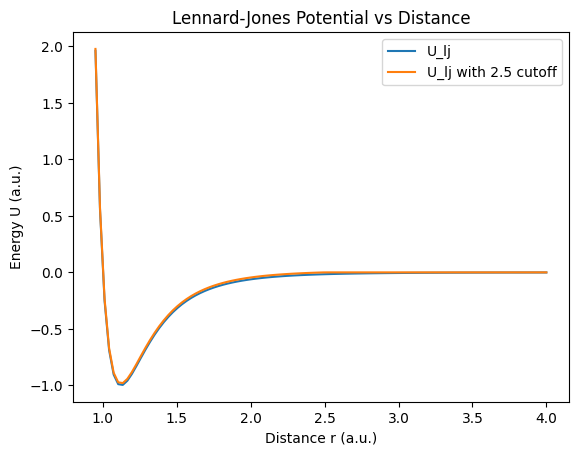

In [220]:
def magnitude2(x):
    return (x*x).sum(axis=0)

def pair_U_lj(x):
    return 4*(x**-6 - 1)*x**-6

# R_CUTOFF = L.min()/2
R_CUTOFF = 2.5
R_CUTOFF2 = R_CUTOFF**2
U_CUTOFF = pair_U_lj(R_CUTOFF)
print(f"R_CUTOFF: {R_CUTOFF}")
print(f"U_CUTOFF: {U_CUTOFF}")

def pair_U_lj_vec(r):
    r2 = magnitude2(r)
    return (r2<R_CUTOFF2) * (4*(r2**-3 - 1)*r2**-3 - U_CUTOFF)
    # return 4*(r2**-3 - 1)*r2**-3 - U_CUTOFF

def pair_F_lj_vec(r):
    r2 = magnitude2(r)
    return (r2<R_CUTOFF2) * (-48*(r2**-3 - 0.5)*r2**-4 * r)

print("testing with r as [xs, ys]")
rtest = np.array([[1,2,3],[2,3,4]], dtype=float)
print(rtest)
print(magnitude2(rtest))
print(pair_U_lj_vec(rtest))
print(pair_F_lj_vec(rtest))

print()
print("testing with r as [x matrix, y matrix]")
rmat = np.array([
    [[1,1,1],[2,2,2],[3,3,3]],
    [[2,3,4],[2,3,4],[2,3,4]],
], dtype=float)
print(magnitude2(rmat))
print(pair_U_lj_vec(rmat))
print(pair_F_lj_vec(rmat))

x = np.linspace(0.95,4,100)
plt.plot(x,pair_U_lj(x), label="U_lj")
plt.plot(x,pair_U_lj_vec(np.array([x,[0]*100])), label="U_lj with 2.5 cutoff")

plt.title("Lennard-Jones Potential vs Distance")
plt.xlabel("Distance r (a.u.)")
plt.ylabel("Energy U (a.u.)")
plt.legend()
plt.show()


(2, 110, 110)
-3.706400706759978
(2, 110, 110)
(2, 110)


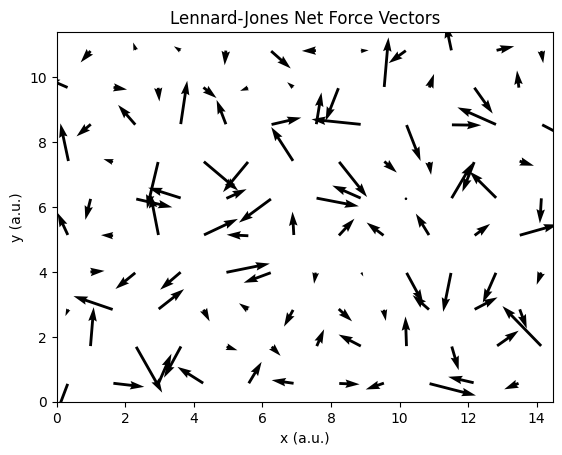

In [223]:
x = r[0]
def pair_displacements_1D(x):
    return -np.diff(np.meshgrid(x,x),axis=0)[0]

def pair_displacements(r): # scuffed implmentation, will change later?
    return np.array([
        (s[i]/2+pair_displacements_1D(x))%s[i]-s[i]/2
        for i,x in enumerate(r)
    ])

def magnitudes(v):
    return np.sqrt(np.sum(v**2,axis=0))

def pair_distances(r):
    return magnitudes(pair_displacements(r))

displacements = pair_displacements(r*L)
print(displacements.shape)

diag_mask = np.identity(N,dtype=int)==1

Us = pair_U_lj_vec(displacements)
Us[diag_mask] = 0
Us = Us.sum()
U_av = Us / N
print(U_av)

F = pair_F_lj_vec(displacements)
F[:,diag_mask] = 0
print(F.shape)
F_net = F.sum(axis=2)
print(F_net.shape)

# plt.quiver(np.repeat(r[0],N),np.repeat(r[1],N), displacements[0,:,:].ravel(),displacements[1,:,:].ravel(), angles="xy", scale=1, scale_units="xy")
def plot_each_arrow(r,A,color=None):
    if color is None: color=np.ones(len(A[0])**2)
    return plt.quiver(
        *[np.repeat(x,N)for x in r],
        *[A[i,:,:].ravel() for i in range(DIM)],
        color,
        angles="xy", scale=1, scale_units="xy")
# plot_each_arrow(r,lj_forces,magnitudes(lj_forces))
# plt.show()

# plt.title("Displacement Vectors")
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(r,displacements,magnitudes(displacements))
# plt.show()

# plt.title("Lennard-Jones Force Vectors")
# plt.xlim(0, L)
# plt.ylim(0, L)
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(
#     r,
#     lj_forces / magnitudes(lj_forces),
#     np.clip(magnitudes(lj_forces),0,1),
# )
# plt.colorbar()
# plt.text(L*0.1,L*0.1, "Forces are clipped with upper bound 1")
# plt.show()

plt.title("Lennard-Jones Net Force Vectors")
plt.xlim(0, s[0])
plt.ylim(0, s[1])
plt.xlabel("x (a.u.)")
plt.ylabel("y (a.u.)")
plt.quiver(*r, *F_net, angles="xy", )
plt.show()

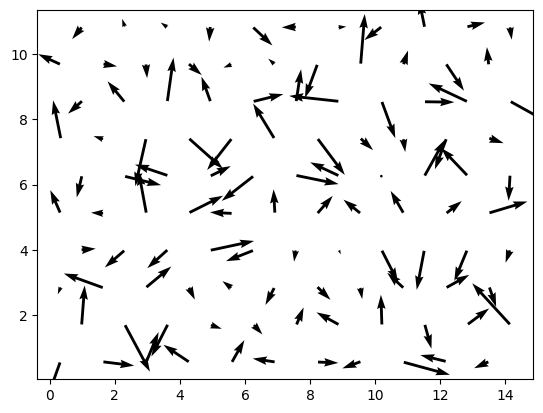

In [190]:
class System():
    def __init__(self, r0, v0, L, dim, N, steps, dt, T_target=None):
        self.N = N
        self.dt = dt
        self.dim = dim

        self.rs = np.zeros((steps, dim, N))
        self.rs[0] = r0
        self.vs = np.zeros((steps, dim, N))
        self.vs[0] = v0
        self.L = L
        self.V = np.prod(L)

        # self.displacements = System.pair_displacements(self.rs[0])
        # self.Fs = np.zeros((steps, dim, N))
        # self.calc_F(0)
        self.displacements = System.pair_displacements(self.rs[0])
        self.calc_neighbours(0)
        self.calc_neigh_displacements(0)
        self.Fs = np.zeros((steps, dim, N))
        self.calc_neigh_F(0)

        self.KEs = np.zeros(steps)
        self.Ts = np.zeros(steps)
        self.Us = np.zeros(steps)
        self.Ps = np.zeros(steps)
        self.take_measurements(0)

        self.T_target = T_target
        self.nu = 20
        self.T_ts = -np.log(rng.uniform(size=N))/self.nu

    def step_state(self, i):
        self.velocity_verlet(i)
        
        # periodic boundary wrap
        self.rs[i+1] = (self.rs[i+1].T % self.L.T).T

        self.take_measurements(i+1)

        self.a_thermostat(i, self.T_target)

    def calc_neigh_displacements(self,i):
        self.neigh_displacements = [
            ((self.L.T/2+(self.rs[i,:,ns]-self.rs[i,:,j]))%self.L.T-self.L.T/2).T
            for j,ns in enumerate(self.neighbours)
        ] # N x dim x len(ns)

    def calc_neigh_F(self,i):      
        self.Fs[i] = np.array([
            pair_F_lj_vec(np.array(r)).sum(axis=1)
            for r in self.neigh_displacements
        ]).T

    def calc_neigh_U(self,i):
        U = np.array([
            pair_U_lj_vec(np.array(r)).sum()
            for r in self.neigh_displacements
        ]).T
        self.Us[i] = U.sum() / self.N

    def calc_neighbours(self,i):
        skin = 0.35
        rv2 = (R_CUTOFF+skin)**2
        self.neighbours = [
            [n for n in range(N)
             if 0 < magnitude2(self.displacements[:,m,n]) < rv2]
            for m in range(self.N)
        ]
        self.drv = skin
        # self.neigh_t = (skin/(magnitude2(self.vs[i])).max()**.5)

    def a_thermostat(self, i, T):
        if T != None:
            self.T_ts -= self.dt
            ma = self.T_ts < 0
            for j in range(self.dim):
                self.vs[i,j,ma] = rng.normal(0, T_i**0.5, ma.sum())
            self.T_ts[ma] = -np.log(rng.uniform(size=ma.sum()))/self.nu

    def take_measurements(self,i):
        # self.calc_U(i)
        self.calc_neigh_U(i)
        self.KEs[i] = (self.vs[i]**2).sum() / self.N / 2
        self.Ts[i] = self.KEs[i] * 2 / self.dim
        vir = (self.rs[i] * self.Fs[i]).sum()
        self.Ps[i] = (self.N * self.Ts[i] + vir/self.dim) / self.V

    def velocity_verlet(self, i):
        dt = self.dt
        self.rs[i+1] = self.rs[i] + self.vs[i]*dt + self.Fs[i]/2 * dt**2
        # self.displacements = System.pair_displacements(self.rs[i+1])
        # self.calc_F(i+1)
        self.drv -= dt * magnitude2(self.vs[i]).max()**.5
        if self.drv < 0:
            self.displacements = System.pair_displacements(self.rs[i+1])
            self.calc_neighbours(i+1)
        self.calc_neigh_displacements(i+1)
        self.calc_neigh_F(i+1)

        self.vs[i+1] = self.vs[i] + (self.Fs[i]+self.Fs[i+1])/2*dt

    def calc_F(self,i):
        lj_forces = pair_F_lj_vec(self.displacements)
        for j in range(self.dim):
            np.fill_diagonal(lj_forces[j,:],0)
        self.Fs[i] = lj_forces.sum(axis=2)

    def calc_U(self,i):
        U = pair_U_lj_vec(self.displacements)
        np.fill_diagonal(U,0)
        self.Us[i] = U.sum() / self.N

    @staticmethod
    def pair_displacements_1D(x):
        return -np.diff(np.meshgrid(x,x),axis=0)[0]

    @staticmethod
    def pair_displacements(r):
        return np.array([
            (s[i]/2+System.pair_displacements_1D(x))%s[i]-s[i]/2
            for i,x in enumerate(r)
        ])

t_total,dt = 10,0.001
steps = int(t_total//dt)
test = System(r,v,s,DIM,N,steps,dt)
plt.quiver(*test.rs[0],*test.Fs[0],angles="xy")
# print(L)
# print(test.neigh_displacements[0])
# print(len(test.neigh_displacements),test.neigh_displacements[0].shape)
# print( pair_F_lj_vec(test.neigh_displacements[0]))

In [191]:
def time_evolution(r,v,L,dim,N,steps,dt, T_target):
    system = System(r,v,L,dim,N,steps, dt, T_target=T_target)
    for i in range(steps-1):
        system.step_state(i)
    return system

In [193]:
t_total,dt = 10,0.001
steps = int(t_total//dt)
T_target = 0.5

system = time_evolution(r,v,s,DIM,N,steps,dt, T_target)
rs = system.rs; vs = system.vs

t = np.arange(steps)*dt
KEs = system.KEs
Us = system.Us
Ps = system.Ps

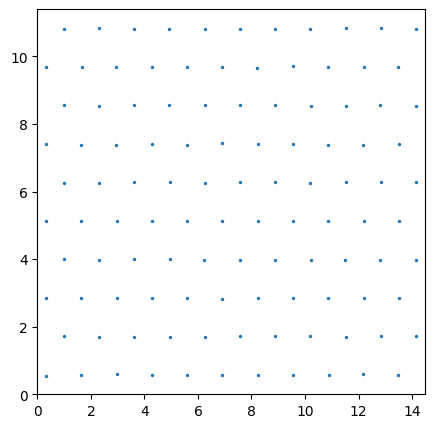

In [197]:
ANIMATE = True
if ANIMATE:
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    points = ax.scatter(*rs[0],s=2)

    fps = 30
    t_anim = 5
    k = steps//(fps*t_anim) # inverse frame density
    nframes = steps // k

    ax.set_xlim(0, s[0])
    ax.set_ylim(0, s[1])
    def animation_frame(i):
        points.set_offsets(rs[i*k].T)

    lj_anim = animation.FuncAnimation(fig, animation_frame, frames=nframes)
    lj_anim.save("test.gif", writer="pillow", fps=fps, dpi=100)

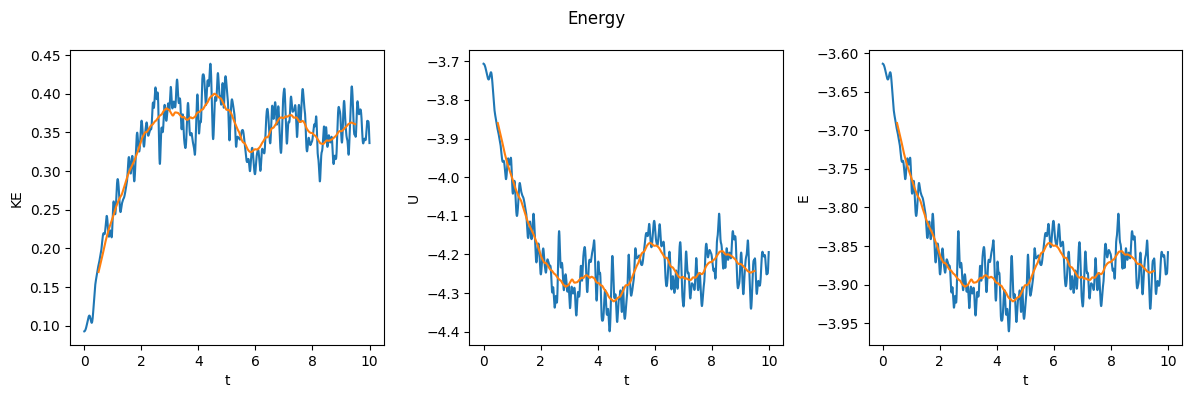

In [195]:
def window(size):
    return np.ones(size)/float(size)
WLEN = 1000

fig,(ax1,ax2,ax3) = plt.subplots(1,3)

KEs_win = np.convolve(KEs, window(WLEN),'same')[WLEN//2:-WLEN//2]
ax1.plot(t,KEs)
ax1.plot(t[WLEN//2:-WLEN//2], np.convolve(KEs, window(WLEN),'same')[WLEN//2:-WLEN//2])
ax1.set_ylabel("KE")
ax1.set_xlabel("t")

Us_win = np.convolve(Us, window(WLEN),'same')[WLEN//2:-WLEN//2]
ax2.plot(t,Us)
ax2.plot(t[WLEN//2:-WLEN//2], np.convolve(Us, window(WLEN),'same')[WLEN//2:-WLEN//2])
ax2.set_ylabel("U")
ax2.set_xlabel("t")

Es = KEs + Us
Es_win = KEs_win + Us_win
ax3.plot(t,Es)
ax3.plot(t[WLEN//2:-WLEN//2], Es_win)
ax3.set_ylabel("E")
ax3.set_xlabel("t")

fig.suptitle("Energy")
fig.subplots_adjust(top=0.90)
fig.set_size_inches(12,4)
fig.tight_layout(pad=1)
fig.show()

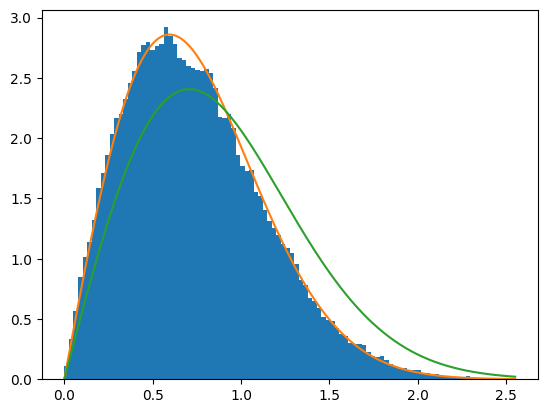

In [196]:
v2s = vs**2
T_WIN = WLEN*6
v2s = v2s[-T_WIN-1:-1]

T = v2s.mean()
# D = lambda v: (2*np.pi*T)**(-3/2) * 4*np.pi*v**2 * np.exp(-v**2/(2*T))
D = lambda v: (1/T) * v * np.exp(-v**2/(2*T))
D_target = lambda v: (1/T_target) * v * np.exp(-v**2/(2*T_target))

v_abs = np.sqrt(v2s.sum(axis=1))
v_abs = np.concatenate(v_abs)
v_range = np.linspace(0,v_abs.max(),1000)

fig, ax = plt.subplots()
# ax.hist(v_abs)
counts, bins = np.histogram(v_abs, bins=100)
ax.stairs(counts/T_WIN, bins, fill=True)
ax.plot(v_range, D(v_range)*N * (bins[1]-bins[0]))
ax.plot(v_range, D_target(v_range)*N * (bins[1]-bins[0]))
fig.show()